In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_add_pool, GraphConv
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
from statistics import mean
import uproot

In [2]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
path_to_tree = "DecayTreeTuple/tuple"

def rename_columns(df):
    new_columns = {}
    for col in df.columns:
        if "_BDTTag_" in col:
            new_columns[col] = col.replace("_BDTTag_", "_SVtag_")
    df.rename(columns=new_columns, inplace=True)

def extract_float(awk_array):
    return awk_array[0] if len(awk_array) > 0 else None

In [ ]:
# Read the ROOT file
tree = uproot.open("Dijet_cc_pt20_50_dw.root" + ":" + path_to_tree)
cc_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=1000)

# Clean column names and remove unwanted columns
cc_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in cc_df.columns]
rename_columns(cc_df)
columns_to_remove = [col for col in cc_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
cc_df.drop(columns=columns_to_remove, inplace=True)
for col in cc_df.columns:
    if "SVtag" in col:
        cc_df[col] = cc_df[col].apply(extract_float)
tree.close()

# Read the ROOT file
tree = uproot.open("Dijet_bb_pt20_50_dw.root" + ":" + path_to_tree)
bb_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=1000)

# Clean column names and remove unwanted columns
bb_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in bb_df.columns]
rename_columns(bb_df)
columns_to_remove = [col for col in bb_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
bb_df.drop(columns=columns_to_remove, inplace=True)
for col in bb_df.columns:
    if "SVtag" in col:
        bb_df[col] = bb_df[col].apply(extract_float)
tree.close()

In [5]:
# Read the ROOT file
tree = uproot.open("Dijet_cc_pt50_dw.root" + ":" + path_to_tree)
cc50_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=1000)

# Clean column names and remove unwanted columns
cc50_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in cc50_df.columns]
rename_columns(cc50_df)
columns_to_remove = [col for col in cc50_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
cc50_df.drop(columns=columns_to_remove, inplace=True)
for col in cc50_df.columns:
    if "SVtag" in col:
        cc50_df[col] = cc50_df[col].apply(extract_float)
tree.close()

# Read the ROOT file
tree = uproot.open("Dijet_bb_pt50_dw.root" + ":" + path_to_tree)
bb50_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=1000) 

# Clean column names and remove unwanted columns
bb50_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in bb50_df.columns]
rename_columns(bb50_df)
columns_to_remove = [col for col in bb50_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
bb50_df.drop(columns=columns_to_remove, inplace=True)
for col in bb50_df.columns:
    if "SVtag" in col:
        bb50_df[col] = bb50_df[col].apply(extract_float)
tree.close()

In [22]:
weights = {
    "cc_df": 1,
    "bb_df": 1,
    "cc50_df": 0.02880875704,
    "bb50_df": 0.03073569429,
}

for df_name, weight in weights.items():
    globals()[df_name]['weights'] = weight

sig_df = pd.concat([cc_df, cc50_df])
bkg_df = pd.concat([bb_df, bb50_df])

In [23]:
print(f'There are {len(sig_df)} c-jet events (signal)')
print(f'There are {len(bkg_df)} b-jet events (background)')

There are 2000 c-jet events (signal)
There are 2000 b-jet events (background)


In [24]:
# Read from csv and assign truth labels
sig_df['IsC'] = 1
bkg_df['IsC'] = 0

# Filter columns to include only leading jet data and truth labels
sig_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsC|weights")]]
bkg_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsC|weights")]]

# Apply cuts and truth matching
sig_df = sig_df[(sig_df['Jet0_MC_Match'] == 1) &
                (sig_df['Jet0_MC_Jet_EfD'] > 0.6) &
                (sig_df['Jet0_PT'] > 20000) &
                (sig_df['Jet0_Eta'].between(2.2, 4.4))]

bkg_df = bkg_df[(bkg_df['Jet0_MC_Match'] == 1) &
                (bkg_df['Jet0_MC_Jet_EfB'] > 0.6) &
                (bkg_df['Jet0_PT'] > 20000) &
                (bkg_df['Jet0_Eta'].between(2.2, 4.4))]

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)

In [25]:
print(f"Efficiency of signal truth matching is: {len(sig_df)/len(cc_df):.4f}")
print(f"Efficiency of background truth matching is: {len(bkg_df)/len(bb_df):.4f}")
print('')
print(f"Total events after truth matching: {len(combined_df)}")
print(f"Number of c-jets after truth matching: {len(sig_df)}")

Efficiency of signal truth matching is: 0.3860
Efficiency of background truth matching is: 0.6570

Total events after truth matching: 1043
Number of c-jets after truth matching: 386


In [26]:
# Define feature columns including jet-level and daughter-level features
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

# Prepare features by converting daughter information to lists and duplicating jet-level features
def prepare_features(df, jet_cols, daughter_cols):
    # Duplicate data to lists matching the number of daughters/nodes per jet/row
    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)

    # Convert string values into list of floats
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

df = prepare_features(combined_df, jet_cols, daughter_cols)

In [27]:
# Split data into training, validation, and test sets
sig_df = df[df['IsC'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
bkg_df = df[df['IsC'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate dataset sizes from number of c-jets
half_train_size = int((sum(combined_df.IsC)*0.8)/2)
half_test_size = int((sum(combined_df.IsC)*0.2)/2)

# Split into training, testing, and validation data
train_df = pd.concat([sig_df.head(half_train_size), bkg_df.head(half_train_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of training data is: {len(train_df)}')

test_df = pd.concat([sig_df.tail(half_test_size), bkg_df.tail(half_test_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of testing data is: {len(test_df)}')

validation_df = pd.concat([sig_df.iloc[half_train_size:-half_test_size], bkg_df.iloc[half_train_size:-half_test_size]]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of validation data is: {len(validation_df)}')

Length of training data is: 308
Length of testing data is: 76
Length of validation data is: 659


In [28]:
print('Ratio of c to b in datasets:')
print(f'    Training data: {sum(train_df.IsC)/len(train_df)}')
print(f'    Testing data: {sum(test_df.IsC)/len(test_df)}')
print(f'    Validation data: {sum(validation_df.IsC)/len(validation_df)}')

Ratio of c to b in datasets:
    Training data: 0.5
    Testing data: 0.5
    Validation data: 0.2943854324734446


In [29]:
# Create graphs for training and testing
def create_graphs(df, feature_cols):

    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for idx, features in enumerate(features_list):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Create fully connected graph
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()
        edge_weight = torch.tensor([df['weights'].iloc[idx]] * edge_index.size(1), dtype=torch.float) 

        y = torch.tensor([df['IsC'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Create graphs for training and testing
train_data = create_graphs(train_df, feature_cols)
test_data = create_graphs(test_df, feature_cols)

# Load data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [31]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = GraphConv(len(feature_cols), hidden_channels)
        self.ln1 = LayerNorm(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.ln2 = LayerNorm(hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.ln3 = LayerNorm(hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.ln4 = LayerNorm(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = Dropout(0.3)

    def forward(self, x, edge_index, batch, edge_weight):        
        x = self.conv1(x, edge_index, edge_weight)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.ln3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index, edge_weight)
        x = self.ln4(x)
        x = F.relu(x)

        x = global_add_pool(x, batch)
        x = self.lin(x)
        return x.squeeze(1)
    
model = GNN()
model = model.to(device)

In [33]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5) # reduce lr by 0.5 every 5 epochs


# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch, data.edge_weight)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch, data.edge_weight)
            loss = criterion(out, data.y.float())
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
            total_loss += loss.item() * data.num_graphs

        avg_loss = total_loss / len(loader.dataset)
        acc = total_correct / total_samples
    return avg_loss, acc

# Training parameters
num_epochs = 200

# Initialize lists for storing loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# Training loop
for epoch in range(num_epochs):

    train_loss = train()
    train_loss_values.append(train_loss)

    train_acc = test(train_loader)[1]
    train_acc_values.append(train_acc)

    test_loss, test_acc = test(test_loader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    scheduler.step(test_loss)

    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    # Save the model and results every 50 epochs
    if (epoch + 1) % 50 == 0:
        # Overwrite the existing model file
        torch.save(model.state_dict(), 'cb50_model1.pth')
        print('Model saved as cb50_model1.pth.')

        # Save the loss and accuracy values to a CSV file, overwriting the existing file
        results_df = pd.DataFrame({
            'Epoch': list(range(1, epoch + 2)),
            'Train Loss': train_loss_values,
            'Test Loss': test_loss_values,
            'Train Accuracy': train_acc_values,
            'Test Accuracy': test_acc_values
        })
        results_df.to_csv('cb50_training1.csv', index=False)
        print('Training results saved as cb50_training1.csv.')

torch.save(model.state_dict(), 'cb50_model1.pth')
print('Model saved as cb50_model1.pth. Training complete.')

results_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs+1)),
    'Train Loss': train_loss_values,
    'Test Loss': test_loss_values,
    'Train Accuracy': train_acc_values,
    'Test Accuracy': test_acc_values
})

# Save the loss and accuracy values to a CSV file
results_df.to_csv('cb50_training1.csv', index=False)
print('Training results saved as cb50_training1.csv. Training complete.')

Epoch: 001, Train Loss: 0.7148, Test Loss: 0.7437, Train Acc: 0.6169, Test Acc: 0.5789
Epoch: 002, Train Loss: 0.7389, Test Loss: 0.6948, Train Acc: 0.6494, Test Acc: 0.6316
Epoch: 003, Train Loss: 0.7123, Test Loss: 0.7477, Train Acc: 0.6234, Test Acc: 0.6184
Epoch: 004, Train Loss: 0.7248, Test Loss: 0.6976, Train Acc: 0.6461, Test Acc: 0.6184
Epoch: 005, Train Loss: 0.6996, Test Loss: 0.6376, Train Acc: 0.6883, Test Acc: 0.6974
Epoch: 006, Train Loss: 0.7682, Test Loss: 0.6911, Train Acc: 0.6461, Test Acc: 0.6184
Epoch: 007, Train Loss: 0.6902, Test Loss: 0.7187, Train Acc: 0.6299, Test Acc: 0.6184
Epoch: 008, Train Loss: 0.7429, Test Loss: 0.7004, Train Acc: 0.6429, Test Acc: 0.6316
Epoch: 009, Train Loss: 0.7129, Test Loss: 0.6658, Train Acc: 0.6721, Test Acc: 0.6711
Epoch: 010, Train Loss: 0.6936, Test Loss: 0.6519, Train Acc: 0.6721, Test Acc: 0.6842
Epoch: 011, Train Loss: 0.6591, Test Loss: 0.6777, Train Acc: 0.6656, Test Acc: 0.6579
Epoch: 012, Train Loss: 0.7007, Test Loss: 

In [34]:
# Reload training data to produce plots
training = pd.read_csv('cb50_training1.csv')
train_loss_values = training['Train Loss'].to_list()
test_loss_values = training['Test Loss'].to_list()
train_acc_values = training['Train Accuracy'].to_list()
test_acc_values = training['Test Accuracy'].to_list()

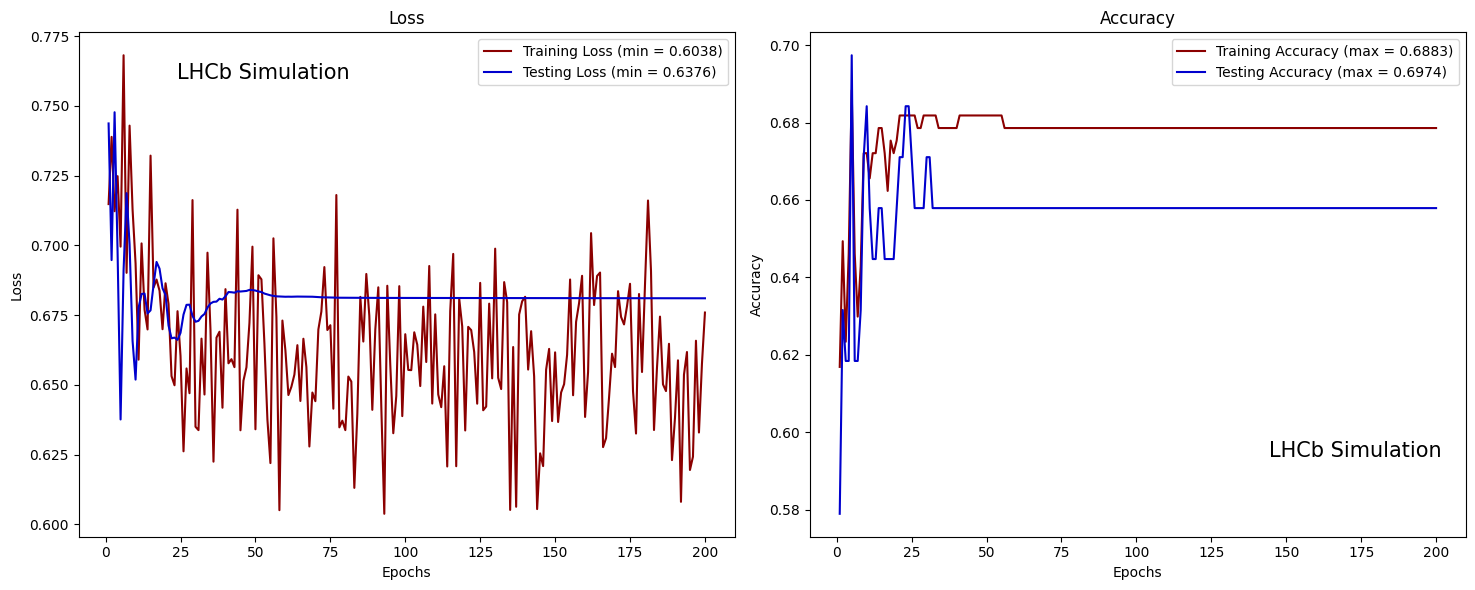

In [35]:
# Plot Loss and Accuracy
def plot_training_results():
    epochs = range(1, len(train_loss_values) + 1)

    mean_train_loss = mean(train_loss_values)
    mean_test_loss = mean(test_loss_values)
    mean_train_acc = mean(train_acc_values)
    mean_test_acc = mean(test_acc_values)

    min_train_loss = min(train_loss_values)
    min_test_loss = min(test_loss_values)
    max_train_acc = max(train_acc_values)
    max_test_acc = max(test_acc_values)

    final_train_loss = train_loss_values[-1]
    final_test_loss = test_loss_values[-1]
    final_train_acc = train_acc_values[-1]
    final_test_acc = test_acc_values[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot Loss
    ax1.plot(epochs, train_loss_values, color='darkred', label=(f"Training Loss (min = {min_train_loss:.4f})"))
    ax1.plot(epochs, test_loss_values, color='mediumblue', label=(f"Testing Loss (min = {min_test_loss:.4f})"))
        
    ax1.text(0.15, 0.90, "LHCb Simulation", transform=ax1.transAxes, fontsize=15, verticalalignment='bottom')
    #ax1.text(0.85, 0.10, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')

    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy (max = {max_train_acc:.4f})"))
    ax2.plot(epochs, test_acc_values, color='mediumblue', label=(f"Testing Accuracy (max = {max_test_acc:.4f})"))
    
    ax2.text(0.7, 0.15, "LHCb Simulation", transform=ax2.transAxes, fontsize=15, verticalalignment='bottom')
    #ax2.text(0.85, 0.10, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')

    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.style.use('default')
    plt.tight_layout()
    plt.show()
    
plot_training_results()

In [36]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.load_state_dict(torch.load('cb50_model1.pth'))
model = model.to('cpu')
model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch, data.edge_weight)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# Save each array separately
np.save('cb50_fpr.npy', fpr)
np.save('cb50_tpr.npy', tpr)
np.save('cb50_thresholds.npy', thresholds)
np.save('cb50_auc.npy', auc)

In [37]:
chosen_tpr = 0.2
closest_index = np.argmin(np.abs(tpr - chosen_tpr))

# Retrieve the threshold and corresponding FPR for this TPR
chosen_threshold = thresholds[closest_index]
chosen_fpr = fpr[closest_index]

print(f"TPR {chosen_tpr}: Pc {chosen_threshold:.4f}: FPR {chosen_fpr:.4f}")

TPR 0.2: Pc 0.7735: FPR 0.2632


In [38]:
# Get FPRs for TPRs
desired_tpr = [0.2, 0.3, 0.4]

print("Efficiency | FPR ")
for val in desired_tpr:
    closest_index = np.argmin(np.abs(tpr - val))
    chosen_threshold = thresholds[closest_index]
    chosen_fpr = fpr[closest_index]
    print(f"{val}: {chosen_fpr:.4f}")

Efficiency | FPR 
0.2: 0.2632
0.3: 0.2895
0.4: 0.3158


In [39]:
chosen_tpr = 0.2
closest_index = np.argmin(np.abs(tpr - chosen_tpr))

# Retrieve the threshold and corresponding FPR for this TPR
chosen_threshold = thresholds[closest_index]
chosen_fpr = fpr[closest_index]

print(f"TPR {chosen_tpr}: Pc {chosen_threshold:.4f}: FPR {chosen_fpr:.4f}")

TPR 0.2: Pc 0.7735: FPR 0.2632


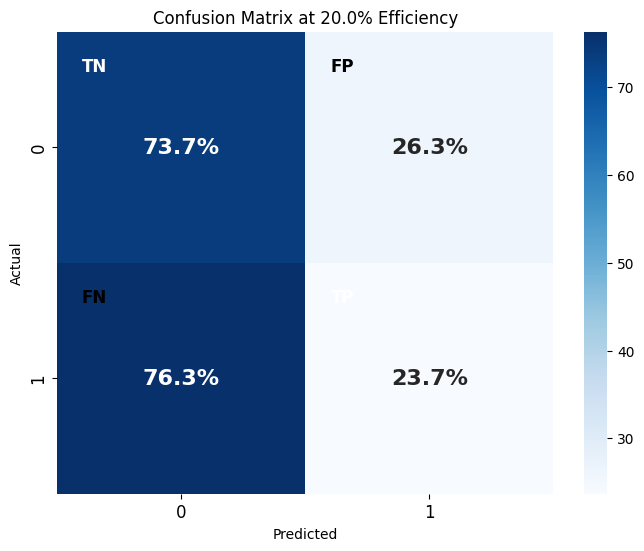

In [40]:
y_pred_binary = (y_scores >= chosen_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)

cm_percentage = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

annot_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = cm_percentage[i, j]
        annot_labels[i, j] = f'{percentage:.1f}%'

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Confusion Matrix at {chosen_tpr * 100}% Efficiency")

ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

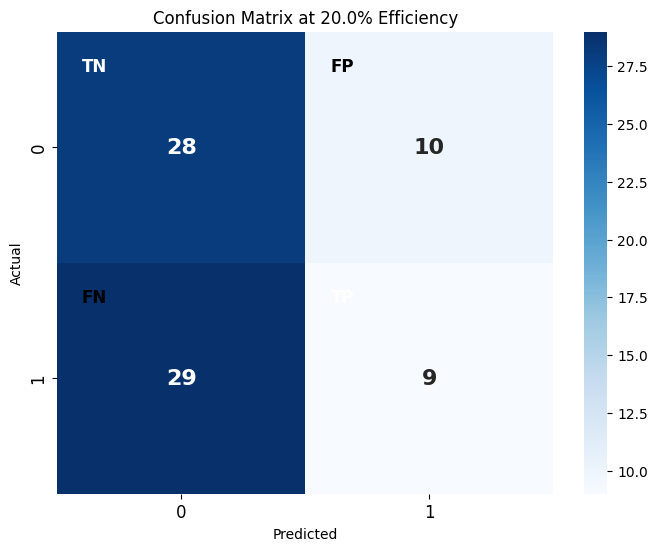

In [41]:
# need to revise for different efficiency
y_pred_binary = (y_scores >= chosen_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)
df_cm = pd.DataFrame(cm)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Confusion Matrix at {chosen_tpr*100}% Efficiency")

# Add TP, FP, FN, TN labels
ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

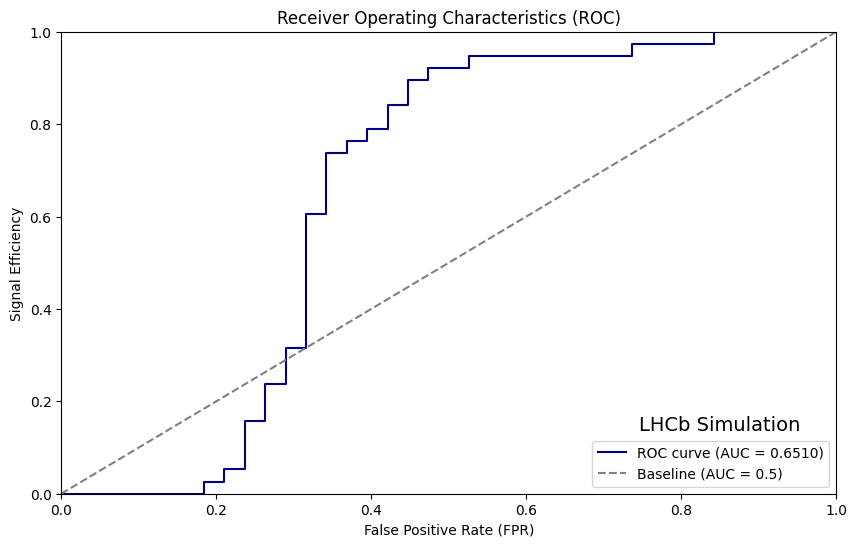

In [42]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Signal Efficiency')
plt.xlabel('False Positive Rate (FPR)')
plt.title('Receiver Operating Characteristics (ROC)')
plt.text(0.85, 0.15, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.legend(loc='lower right')
plt.show()

                                Feature    Importance
0                      Jet0_Daughters_E  9.354922e-02
1                     Jet0_Daughters_pT  8.744481e-03
2                     Jet0_Daughters_ID  4.481455e-03
3                     Jet0_Daughters_pX  6.039004e-03
4                     Jet0_Daughters_pY  3.950984e-03
5                     Jet0_Daughters_pZ  6.285022e-02
6                    Jet0_Daughters_Eta  6.609410e-05
7                    Jet0_Daughters_Phi  3.549643e-05
8                      Jet0_Daughters_Q  9.549782e-06
9                     Jet0_Daughters_IP  1.293411e-03
10                Jet0_Daughters_IPCHI2  2.456062e-01
11                 Jet0_Daughters_IPraw  1.385926e-03
12                   Jet0_Daughters_NNe  5.794061e-03
13                   Jet0_Daughters_NNk  9.840271e-03
14                   Jet0_Daughters_NNp  1.058429e-02
15                  Jet0_Daughters_NNpi  1.194330e-02
16                  Jet0_Daughters_NNmu  1.800239e-02
17                  Jet0_Dau

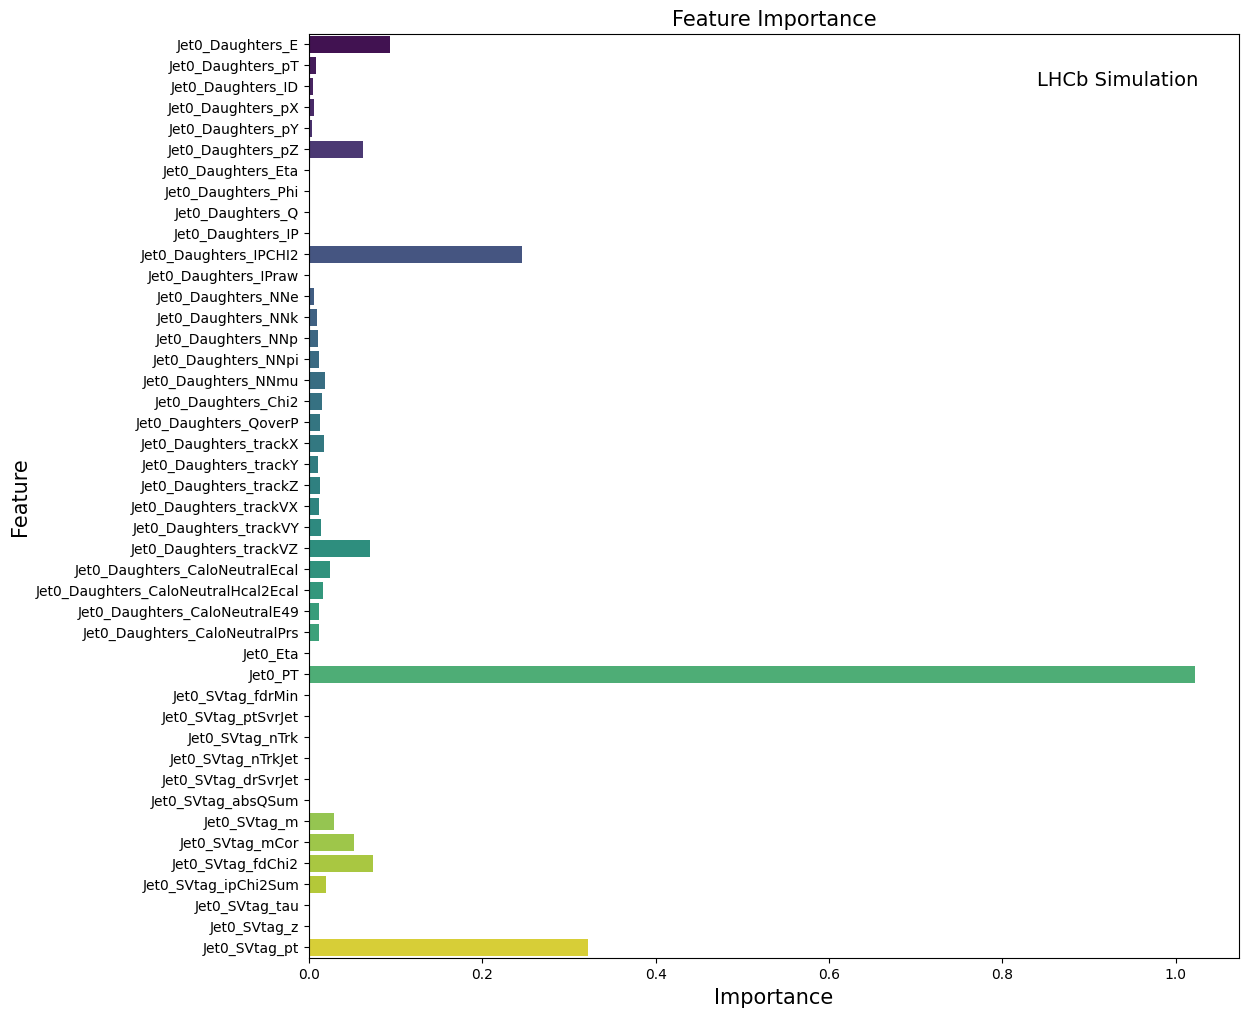

In [47]:
# Prepare model
model.eval()
data = next(iter(test_loader))
x, edge_index, batch = data.x, data.edge_index, data.batch

G = nx.Graph()
edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
G.add_edges_from(edges)

feature_importances = np.zeros(x.size(1))

for feature_idx in range(x.size(1)):
    x_perturbed = x.clone()
    x_perturbed[:, feature_idx] = 0

    # Predict with original features
    with torch.no_grad():
        orig_pred = model(x, edge_index, batch, None)
        perturbed_pred = model(x_perturbed, edge_index, batch, None)

    # Compute importance - difference in predictions
    importance = torch.mean(torch.abs(orig_pred - perturbed_pred))
    feature_importances[feature_idx] = importance

importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importances})
print(importance_df)

plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance', fontsize=15)
plt.text(0.87, 0.95, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.show()

In [48]:
for index, row in importance_df.iterrows():
    feature = row['Feature'] 
    importance = row['Importance']
    if importance > 0.25:
        print(f'{feature} & {importance:4f}')

Jet0_PT & 1.021719
Jet0_SVtag_pt & 0.321684


# Model Probability Output

In [49]:
df = pd.concat([cc_df, bb_df]).reset_index(drop=True)

In [50]:
df = validation_df
chosen_threshold = 0.5

def make_predictions():
    # Select a random integer for sampling
    random_integer = np.random.randint(0, len(df))
    sample_jet = df.iloc[random_integer:random_integer+1].copy()

    # Filter columns related to Jet0
    sample_jet = sample_jet.filter(like='Jet0')

    # Define feature columns
    daughter_cols = [col for col in sample_jet.columns if "_Daughters" in col]
    svtag_cols = ['Jet0_SVtag_fdrMin',
    'Jet0_SVtag_ptSvrJet',
    'Jet0_SVtag_nTrk',
    'Jet0_SVtag_nTrkJet',
    'Jet0_SVtag_drSvrJet',
    'Jet0_SVtag_absQSum',
    'Jet0_SVtag_m',
    'Jet0_SVtag_mCor',
    'Jet0_SVtag_fdChi2',
    'Jet0_SVtag_ipChi2Sum',
    'Jet0_SVtag_tau',
    'Jet0_SVtag_z',
    'Jet0_SVtag_pt']
    jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
    feature_cols = daughter_cols + jet_cols

    for col in jet_cols:
        sample_jet[col] = sample_jet.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)
    for col in daughter_cols:
        sample_jet[col] = sample_jet[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

    # Obtain features of each node within the graph
    features_list = []
    for _, row in sample_jet.iterrows():
        num_nodes = int(row['Jet0_nDaughters'])
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    # Create graph representation with data objects
    data_objects = []
    for features in features_list:
        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        data = Data(x=x, edge_index=edge_index)
        data_objects.append(data)

    for data in data_objects:
        with torch.no_grad():
            output = model(data.x, data.edge_index, data.batch, data.edge_weight)
            probability = torch.sigmoid(output)
            prediction = (probability > chosen_threshold).int()

    print(f'Probability: {probability.item()}')
    if prediction.item() == 1:  
        print(f'Prediction: c-jet')
    if prediction.item() == 0:  
        print(f'Prediction: b-jet')
    return probability.item()

i = 0

for i in range(100):
    make_predictions()

Probability: 0.7577049732208252
Prediction: c-jet
Probability: 0.6133885979652405
Prediction: c-jet
Probability: 0.5505485534667969
Prediction: c-jet
Probability: 0.45877954363822937
Prediction: b-jet
Probability: 0.5732901096343994
Prediction: c-jet
Probability: 0.2227264791727066
Prediction: b-jet
Probability: 0.2643652558326721
Prediction: b-jet
Probability: 0.7657058835029602
Prediction: c-jet
Probability: 0.25231310725212097
Prediction: b-jet
Probability: 0.4890331029891968
Prediction: b-jet
Probability: 0.383127361536026
Prediction: b-jet
Probability: 0.20012183487415314
Prediction: b-jet
Probability: 0.3989831209182739
Prediction: b-jet
Probability: 0.7404796481132507
Prediction: c-jet
Probability: 0.854356586933136
Prediction: c-jet
Probability: 0.43356645107269287
Prediction: b-jet
Probability: 0.1988227516412735
Prediction: b-jet
Probability: 0.7791286110877991
Prediction: c-jet
Probability: 0.8098484873771667
Prediction: c-jet
Probability: 0.7417079210281372
Prediction: c-je

# Create Efficiency Plot

In [51]:
model.load_state_dict(torch.load('cb50_model1.pth'))
model = model.to('cpu')

In [52]:
len(test_df)

76

In [54]:
# Separate b and q data from testing dataset (preprocessed)
c = test_df[test_df.IsC == 1]
b = test_df[test_df.IsC == 0]

c_data = create_graphs(c, feature_cols)
b_data = create_graphs(b, feature_cols)

c_prob = []
b_prob = []

def get_probabilities(data_list):
    prob_list = []
    model.eval()
    with torch.no_grad():
        for data in data_list:
            out = model(data.x, data.edge_index, data.batch, data.edge_weight)
            prob = torch.sigmoid(out).numpy().flatten()
            prob_list.append(prob)
    return np.concatenate(prob_list)

# Compute probabilities for b and q data
c_prob = get_probabilities(c_data)
b_prob = get_probabilities(b_data)

In [55]:
len(c_prob)

38

In [56]:
len(b_prob)

38

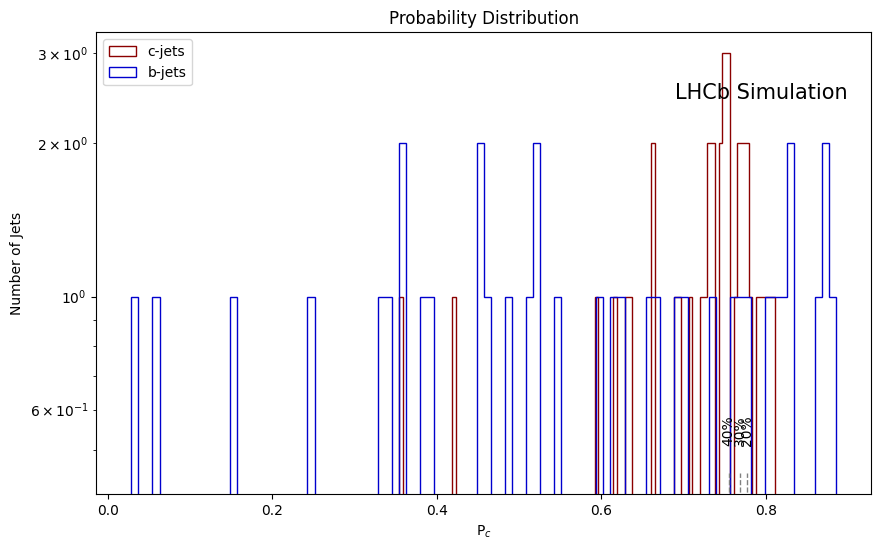

In [57]:
def plot_probability_distribution(c_prob, b_prob, target_efficiencies):

    # Sort c-jet probabilities in descending order for cutoff calculations
    sorted_c_prob = np.sort(c_prob)[::-1]
    
    # Calculate cutoffs for each efficiency level
    cutoffs = {}
    for efficiency in target_efficiencies:
        cutoff_index = int(len(sorted_c_prob) * efficiency)
        cutoffs[efficiency] = sorted_c_prob[cutoff_index - 1] if cutoff_index > 0 else sorted_c_prob[0]
    
    # Plot histograms for b-jet and q-jet probabilities
    plt.figure(figsize=(10, 6))
    c_values, c_bins, _ = plt.hist(c_prob, bins=100, label='c-jets', color='darkred', histtype='step')
    b_values, b_bins, _ = plt.hist(b_prob, bins=100, label='b-jets', color='mediumblue', histtype='step')

    max_y = max(max(c_values), max(b_values))
    
    # Mark cutoffs for selected efficiencies
    for i, (efficiency, cutoff) in enumerate(cutoffs.items()):
        plt.vlines(x=cutoff, ymin=0, ymax=max_y * 0.15, color='grey', linestyle='--', linewidth=1)
        plt.text(cutoff, max_y*0.17, f'{int(efficiency * 100)}%', ha='center', va='bottom', rotation=90)


    plt.xlabel("P$_c$")
    plt.ylabel("Number of Jets")
    plt.text(0.9, max_y * 0.8, "LHCb Simulation", fontsize=15, verticalalignment='bottom', horizontalalignment='right')
    plt.title("Probability Distribution")
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()

target_efficiencies = [0.2, 0.3, 0.4]
plot_probability_distribution(c_prob, b_prob, target_efficiencies)

In [59]:
chosen_tpr = 0.30
closest_index = np.argmin(np.abs(tpr - chosen_tpr))

# Retrieve the threshold and corresponding FPR for this TPR
chosen_threshold = thresholds[closest_index]
chosen_fpr = fpr[closest_index]

print(f"TPR {chosen_tpr}: Pc {chosen_threshold:.4f}: FPR {chosen_fpr:.4f}")

TPR 0.3: Pc 0.8476: FPR 0.0340


In [67]:
c = test_df[test_df.IsC == 1]
# Revert Jet0_PT to one element, not a list
c.loc[:, 'Jet0_PT'] = c['Jet0_PT'].apply(lambda x: x[0] if isinstance(x, list) else x)

pt23_df = c[(c['Jet0_PT'].between(20000, 30000))].reset_index(drop=True)
pt34_df = c[(c['Jet0_PT'].between(30000, 40000))].reset_index(drop=True)
pt45_df = c[(c['Jet0_PT'].between(40000, 50000))].reset_index(drop=True)
pt50_df = c[(c['Jet0_PT'].between(50000, 100000))].reset_index(drop=True)

In [68]:
def make_predictions(df):
    daughter_cols = [col for col in df.columns if "_Daughters" in col]
    svtag_cols = [
        'Jet0_SVtag_fdrMin',
        'Jet0_SVtag_ptSvrJet',
        'Jet0_SVtag_nTrk',
        'Jet0_SVtag_nTrkJet',
        'Jet0_SVtag_drSvrJet',
        'Jet0_SVtag_absQSum',
        'Jet0_SVtag_m',
        'Jet0_SVtag_mCor',
        'Jet0_SVtag_fdChi2',
        'Jet0_SVtag_ipChi2Sum',
        'Jet0_SVtag_tau',
        'Jet0_SVtag_z',
        'Jet0_SVtag_pt'
    ]
    jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
    feature_cols = daughter_cols + jet_cols

    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

    # Get features of each node within the graph
    features_list = []
    for _, row in df.iterrows():
        num_nodes = int(row['Jet0_nDaughters'])
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for features in features_list:
        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()
        edge_weight = torch.ones(edge_index.size(1), dtype=torch.float)

        data = Data(x=x, edge_index=edge_index)
        data_objects.append(data)

    num_c = 0
    for data in data_objects:
        with torch.no_grad():
            output = model(data.x, data.edge_index, data.batch, data.edge_weight)
            probability = torch.sigmoid(output)
            prediction = (probability > chosen_threshold).int()

            if prediction.item() == 1:  
                num_c += 1

    return num_c

In [69]:
num_c23 = make_predictions(pt23_df)
num_c34 = make_predictions(pt34_df)
num_c45 = make_predictions(pt45_df)
num_c50 = make_predictions(pt50_df)

efficiency23 = num_c23 / len(pt23_df)
efficiency34 = num_c34 / len(pt34_df)
efficiency45 = num_c45 / len(pt45_df)
efficiency50 = num_c50 / len(pt50_df)

print(f'Efficiency for pT 20-30 GeV: {efficiency23:.4f}')
print(f'Efficiency for pT 30-40 GeV: {efficiency34:.4f}')
print(f'Efficiency for pT 40-50 GeV: {efficiency45:.4f}')
print(f'Efficiency for pT 50-100 GeV: {efficiency50:.4f}')

Efficiency for pT 20-30 GeV: 0.0000
Efficiency for pT 30-40 GeV: 0.0000
Efficiency for pT 40-50 GeV: 0.0000
Efficiency for pT 50-100 GeV: 0.0000


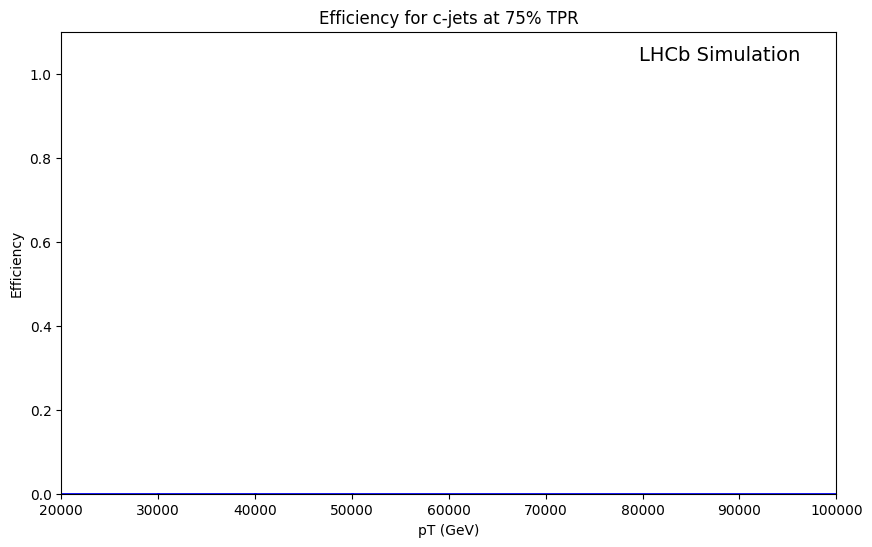

In [70]:
def plot_efficiency_histogram(efficiencies, pt_bins):
    plt.figure(figsize=(10, 6))

    # Calculate bin centers and widths
    bin_centers = (pt_bins[:-1] + pt_bins[1:]) / 2
    bar_width = np.diff(pt_bins)  # Width of the bins

    # Create the histogram by plotting only the tops of the bins
    for i in range(len(efficiencies)):
        plt.plot([pt_bins[i], pt_bins[i+1]], [efficiencies[i], efficiencies[i]], color='blue', linewidth=2)
    plt.xticks(np.arange(20000, 101000, 10000))
    plt.xlabel('pT (GeV)')
    plt.ylabel('Efficiency')
    plt.text(0.85, 0.95, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
    plt.title('Efficiency for c-jets at 75% TPR')
    plt.ylim(0, 1.1)
    plt.xlim(20000, 100000)
    plt.show()

# Custom bin ranges (with unequal bins for the upper range)
pt_bins = np.array([20000, 30000, 40000, 50000, 100000])
efficiencies = [efficiency23, efficiency34, efficiency45, efficiency50]

plot_efficiency_histogram(efficiencies, pt_bins)